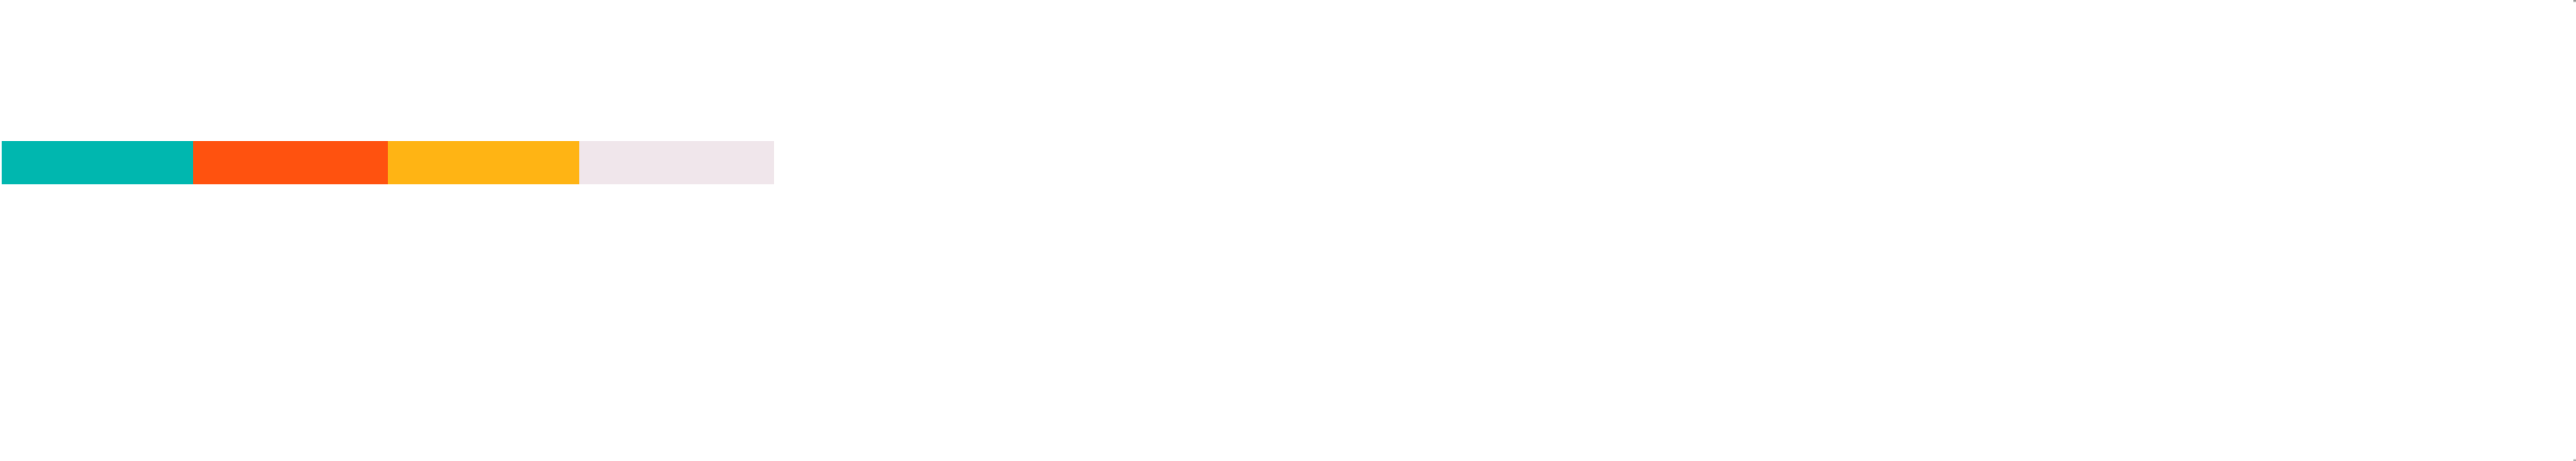

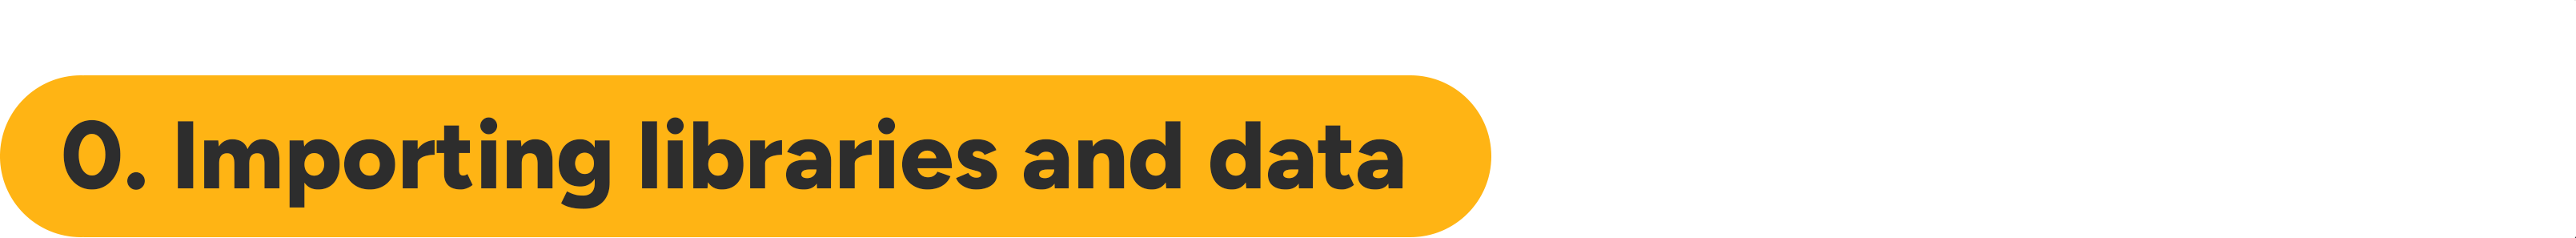

In [2]:
import glob
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import ta
from statsmodels.tsa.stattools import adfuller, kpss
from tsfracdiff import FractionalDifferentiator
from hmmlearn import hmm

sns.set(style='dark', palette='viridis')

In [3]:
directory_path = 'forex_lite'
files = glob.glob(os.path.join(directory_path, '*.csv'))

forex = pd.DataFrame()
content = []
for i in files:
    df = pd.read_csv(i, index_col='Date', header=0)
    content.append(df)

forex = pd.concat(content, axis=1)
forex.dropna(inplace=True)
forex.index = pd.to_datetime(forex.index)

forex

AUDCHF   AUDJPY   CADJPY   EURJPY   GBPSGD  NZDJPY  \
Date                                                                       
2013-03-18 22:05:00  0.98401   99.159   93.246  123.528  1.88498  78.817   
2013-03-18 22:10:00  0.98431   99.167   93.245  123.507  1.88536  78.815   
2013-03-18 22:15:00  0.98440   99.157   93.231  123.536  1.88551  78.810   
2013-03-18 22:20:00  0.98448   99.182   93.206  123.531  1.88563  78.822   
2013-03-18 22:25:00  0.98445   99.229   93.179  123.589  1.88564  78.853   
...                      ...      ...      ...      ...      ...     ...   
2024-05-07 10:05:00  0.59906  101.990  112.977  166.347  1.69644  92.828   
2024-05-07 10:10:00  0.59900  101.995  112.965  166.364  1.69645  92.822   
2024-05-07 10:15:00  0.59904  102.016  112.973  166.376  1.69645  92.828   
2024-05-07 10:20:00  0.59908  102.031  112.991  166.374  1.69680  92.835   
2024-05-07 10:25:00  0.59939  102.044  112.979  166.374  1.69697  92.848   

                       USDNOK  XAGUSD  
Date                                   
2013-03-18 22:05:00   5.79210  28.950  
2013-03-18 22:10:00   5.79153  28.947  
2013-03-18 22:15:00   5.79213  28.956  
2013-03-18 22:20:00   5.79259  28.970  
2013-03-18 22:25:00   5.79234  28.963  
...                       ...     ...  
2024-05-07 10:05:00  10.86585  27.204  
2024-05-07 10:10:00  10.86554  27.205  
2024-05-07 10:15:00  10.86469  27.194  
2024-05-07 10:20:00  10.86573  27.203  
2024-05-07 10:25:00  10.86261  27.218  

[774390 rows x 8 columns]

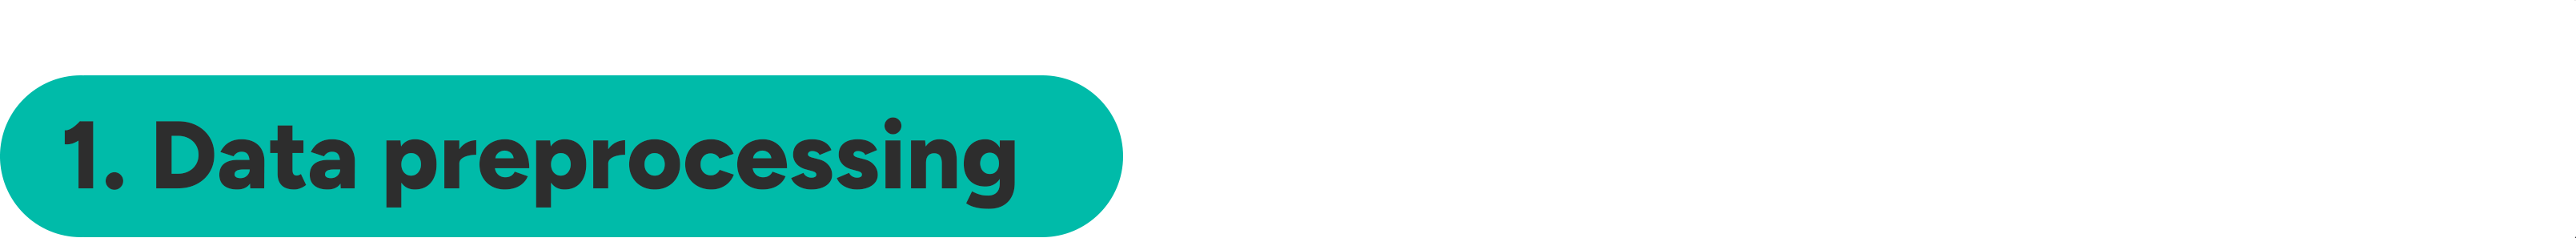

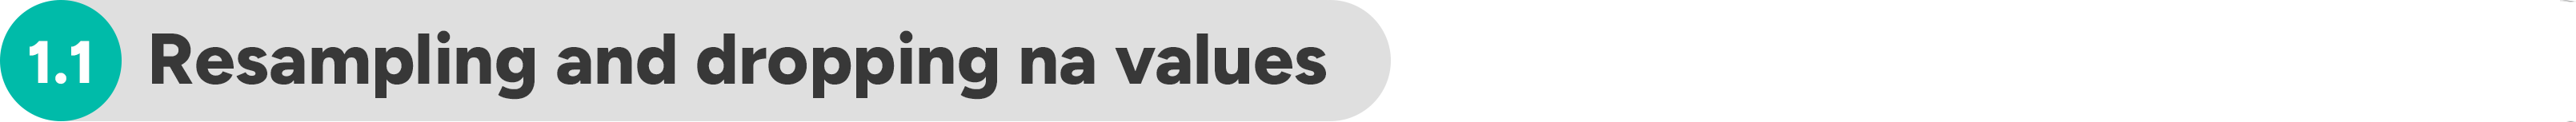

Resampling (5 min interval to daily interval) + dropping nans (for non trading days)

In [4]:
forex_hourly = forex.resample('h').mean()
forex_hourly.dropna(inplace = True)
forex_hourly

AUDCHF      AUDJPY      CADJPY      EURJPY    GBPSGD  \
Date                                                                          
2013-03-18 22:00:00  0.984292   99.257636   93.213818  123.650000  1.885253   
2013-03-18 23:00:00  0.983773   99.266750   93.364167  123.747250  1.884706   
2013-03-19 00:00:00  0.982857   99.364833   93.410417  123.981667  1.885966   
2013-03-19 01:00:00  0.982838   99.306583   93.576833  123.901000  1.886539   
2013-03-19 02:00:00  0.982996   99.268250   93.550083  123.839333  1.886228   
...                       ...         ...         ...         ...       ...   
2024-05-07 06:00:00  0.597843  101.778917  112.825500  166.154167  1.696997   
2024-05-07 07:00:00  0.597818  101.744250  112.707917  166.026583  1.696142   
2024-05-07 08:00:00  0.598695  101.730833  112.694417  165.934000  1.696015   
2024-05-07 09:00:00  0.598909  101.908750  112.905000  166.232167  1.697246   
2024-05-07 10:00:00  0.599072  102.004333  112.976333  166.366000  1.696630   

                        NZDJPY     USDNOK     XAGUSD  
Date                                                  
2013-03-18 22:00:00  78.871818   5.791852  28.958000  
2013-03-18 23:00:00  78.866083   5.789135  28.952000  
2013-03-19 00:00:00  78.888083   5.785881  28.914083  
2013-03-19 01:00:00  78.887750   5.788364  28.930500  
2013-03-19 02:00:00  78.891083   5.788840  28.962333  
...                        ...        ...        ...  
2024-05-07 06:00:00  92.697333  10.853557  27.241917  
2024-05-07 07:00:00  92.639167  10.855920  27.227833  
2024-05-07 08:00:00  92.607250  10.853943  27.217583  
2024-05-07 09:00:00  92.791917  10.858771  27.231333  
2024-05-07 10:00:00  92.826833  10.865512  27.202167  

[65232 rows x 8 columns]

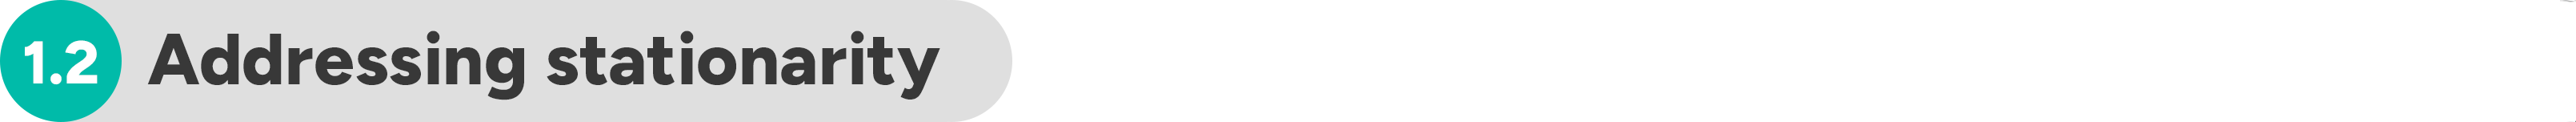

Stationarity is a necessary, non-sufficient condition for the high performance of an ML algorithm.

**PROBLEM**: there is a trade-off between stationarity and memory.
* too much differencing = stationary BUT no memory

**SOLUTION**: use fractional differencing, i.e. minimum degree of differencing, just enuf to pass adf test

Visual inspection

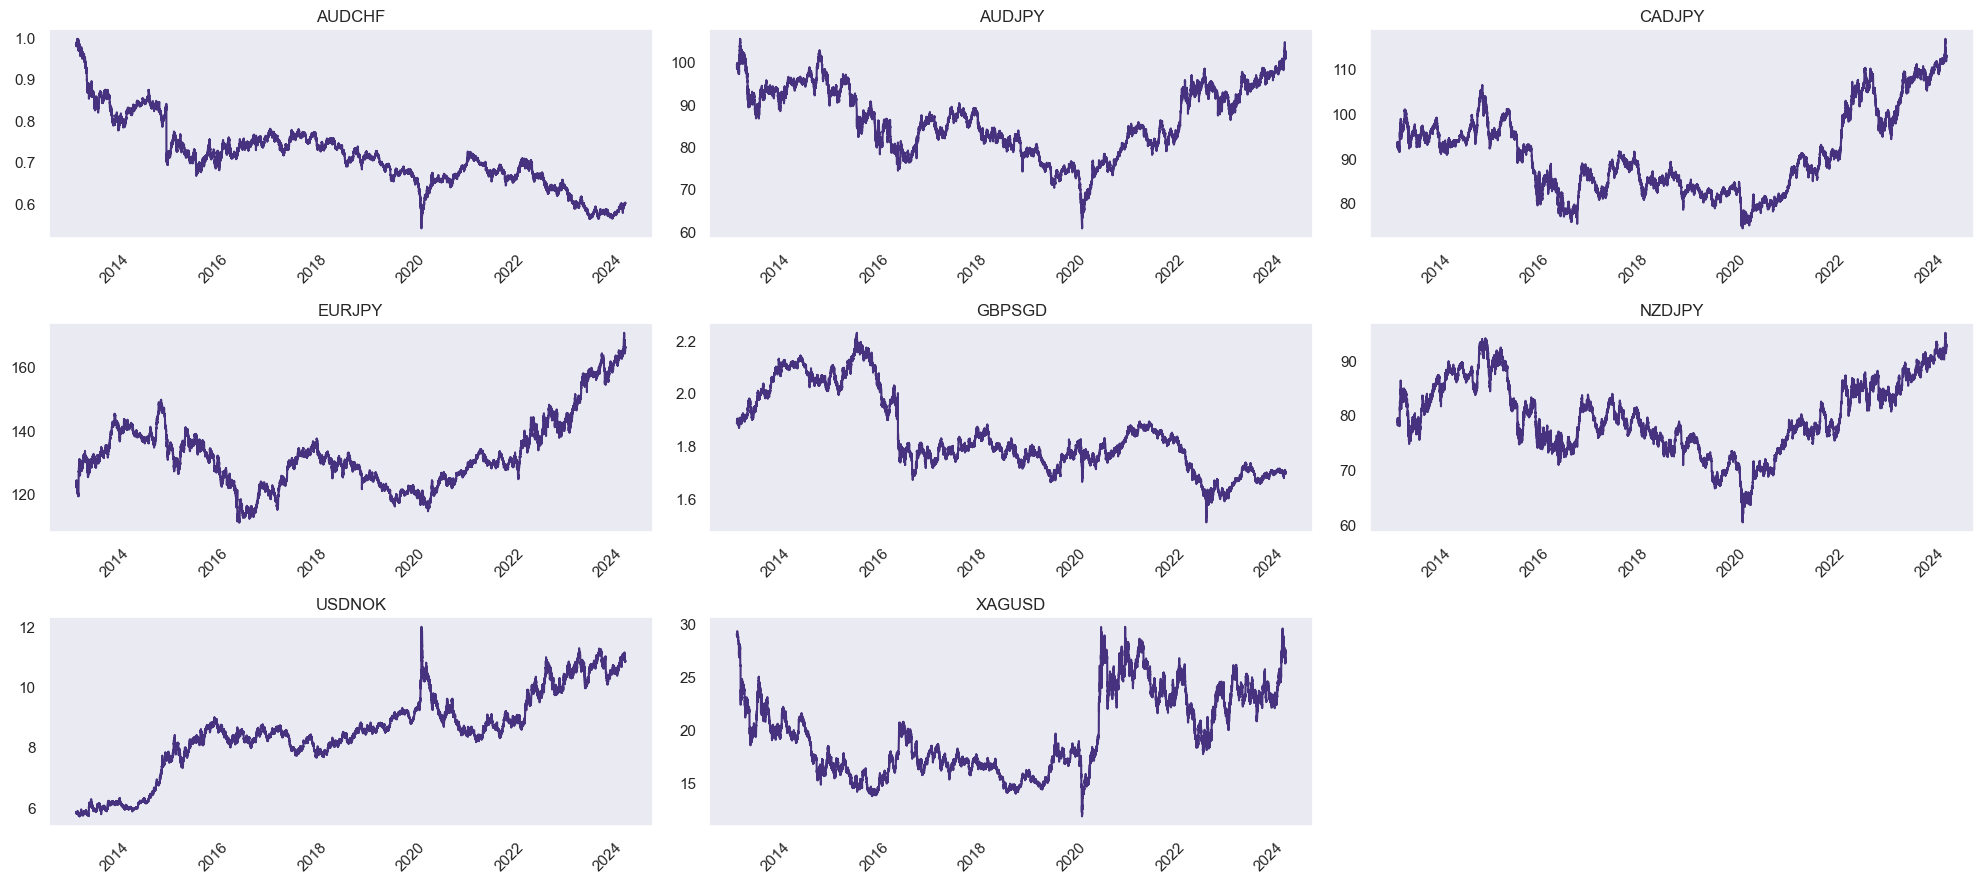

In [5]:
num_plots = len(forex_hourly.columns)
nrows = (num_plots // 3) + (1 if num_plots % 3 else 0)
ncols = min(3, num_plots)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 9))

axes = axes.flatten()

for i, column in enumerate(forex_hourly.columns):
    axes[i].plot(forex_hourly.index, forex_hourly[column])
    axes[i].set_title(column)
    axes[i].tick_params(axis = "x", rotation = 45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

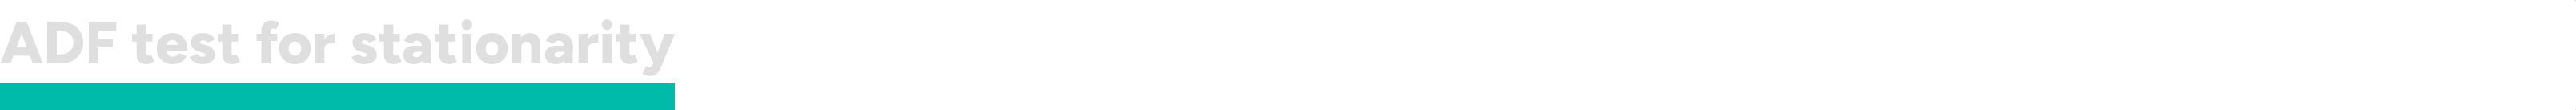

In [6]:
adf_results = []
for pair in forex_hourly.columns:
    result = adfuller(forex_hourly[pair])
    adf_stat = result[0]
    p = result[1]
    adf_results.append((pair, adf_stat, p))

adf_results = pd.DataFrame(adf_results, columns = ['pair', 'adf_stat', 'p'])
display(adf_results)
print(f'\nNumber of pairs with a p-value > 0.05 (non stationary): {sum(adf_results.p > 0.05)} out of {len(adf_results)} pairs.')
adf_non_stationary = adf_results[adf_results["p"] > 0.05].reset_index(drop = True)
adf_non_stationary

# big p = bad

pair  adf_stat         p
0  AUDCHF -3.017752  0.033270
1  AUDJPY -1.827551  0.366872
2  CADJPY -0.909128  0.784952
3  EURJPY -0.654811  0.858110
4  GBPSGD -1.406562  0.579126
5  NZDJPY -1.805088  0.377939
6  USDNOK -1.568622  0.499334
7  XAGUSD -2.674048  0.078638


Number of pairs with a p-value > 0.05 (non stationary): 7 out of 8 pairs.


pair  adf_stat         p
0  AUDJPY -1.827551  0.366872
1  CADJPY -0.909128  0.784952
2  EURJPY -0.654811  0.858110
3  GBPSGD -1.406562  0.579126
4  NZDJPY -1.805088  0.377939
5  USDNOK -1.568622  0.499334
6  XAGUSD -2.674048  0.078638

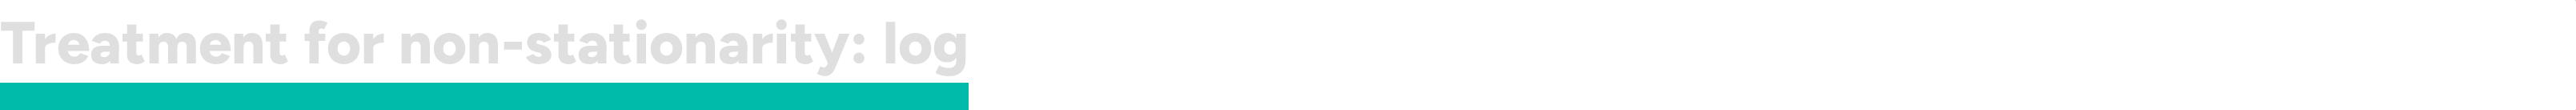

Source: textbook page 160, 161

In [11]:
non_stationary_pairs = []

print('Currency:     p-value')
for column in forex_hourly.columns:
    result = adfuller(forex_hourly[column])
    p_value = result[1]
    print(f'{column}:   {p_value}')
    if p_value > 0.05:
        non_stationary_pairs.append(column)

print("\nNon-stationary pairs (p > 0.05):")
non_stationary_pairs

Currency:     p-value
AUDCHF:   0.03326950572231393
AUDJPY:   0.3668718110590543
CADJPY:   0.7849515798384766
EURJPY:   0.8581098800224066
GBPSGD:   0.5791260968598578
NZDJPY:   0.3779387881412768
USDNOK:   0.49933365808185476
XAGUSD:   0.07863783687410873

Non-stationary pairs (p > 0.05):


['AUDJPY', 'CADJPY', 'EURJPY', 'GBPSGD', 'NZDJPY', 'USDNOK', 'XAGUSD']

all = pretty much non stationary -> log to stabilise a bit

In [8]:
forex_hourly_log = np.log(forex_hourly)
forex_hourly_log.head(2)

AUDCHF    AUDJPY    CADJPY    EURJPY    GBPSGD  \
Date                                                                    
2013-03-18 22:00:00 -0.015833  4.597719  4.534896  4.817455  0.634062   
2013-03-18 23:00:00 -0.016361  4.597811  4.536508  4.818241  0.633772   

                       NZDJPY    USDNOK    XAGUSD  
Date                                               
2013-03-18 22:00:00  4.367824  1.756452  3.365847  
2013-03-18 23:00:00  4.367751  1.755983  3.365639

Since the values of AUDCHF is too close to zero -> negative log prices. Fix: **translation** - adding a constant to value b4 taking log.

In [13]:
a = 1 - np.min(forex_hourly)
forex_hourly_log = np.log(forex_hourly + a)
forex_hourly_log.head()

AUDCHF    AUDJPY    CADJPY    EURJPY    GBPSGD  \
Date                                                                    
2013-03-18 22:00:00  0.368536  4.602356  4.539833  4.821179  0.852958   
2013-03-18 23:00:00  0.368176  4.602447  4.541437  4.821962  0.852725   
2013-03-19 00:00:00  0.367542  4.603430  4.541929  4.823848  0.853262   
2013-03-19 01:00:00  0.367530  4.602847  4.543701  4.823199  0.853506   
2013-03-19 02:00:00  0.367639  4.602462  4.543416  4.822703  0.853373   

                       NZDJPY    USDNOK    XAGUSD  
Date                                               
2013-03-18 22:00:00  4.373656  1.833090  3.381652  
2013-03-18 23:00:00  4.373584  1.832655  3.381448  
2013-03-19 00:00:00  4.373861  1.832134  3.380158  
2013-03-19 01:00:00  4.373857  1.832532  3.380717  
2013-03-19 02:00:00  4.373899  1.832608  3.381799

Checking to see if logging has stabilise the data enuf:

In [16]:
logged_non_stationary_pairs = []

print('Currency:     p-value')
for column in forex_hourly_log.columns:
    result = adfuller(forex_hourly_log[column])
    p_value = result[1]
    print(f'{column}:   {p_value}')
    if p_value > 0.05:
        logged_non_stationary_pairs.append(column)

print("logged non-stationary pairs (p > 0.05):")
logged_non_stationary_pairs

Currency:     p-value
AUDCHF:   0.06958325684492082
AUDJPY:   0.3280035566683641
CADJPY:   0.730029399696569
EURJPY:   0.7957563480904849
GBPSGD:   0.562508708009989
NZDJPY:   0.36420679709714787
USDNOK:   0.4244834815414475
XAGUSD:   0.10531624955663521
logged non-stationary pairs (p > 0.05):


['AUDCHF',
 'AUDJPY',
 'CADJPY',
 'EURJPY',
 'GBPSGD',
 'NZDJPY',
 'USDNOK',
 'XAGUSD']

not enuf -> frac diff (note: were using ADF fuller test result as a benchmark)

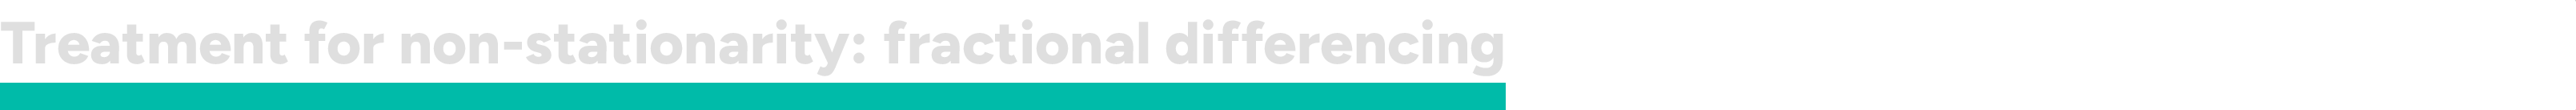

In [24]:
forex_hourly_log_frdiff = forex_hourly_log.copy()
fracDiff = FractionalDifferentiator()

for pair in logged_non_stationary_pairs:
    forex_hourly_log_frdiff[pair] = fracDiff.FitTransform(forex_hourly_log[pair])
display(forex_hourly_log_frdiff)

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


AUDCHF    AUDJPY    CADJPY    EURJPY    GBPSGD  \
Date                                                                    
2013-03-18 22:00:00       NaN       NaN       NaN       NaN       NaN   
2013-03-18 23:00:00       NaN       NaN       NaN       NaN       NaN   
2013-03-19 00:00:00       NaN       NaN       NaN       NaN       NaN   
2013-03-19 01:00:00       NaN       NaN       NaN       NaN       NaN   
2013-03-19 02:00:00       NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2024-05-07 06:00:00  0.005783  0.550536  0.563814  0.610383  0.091530   
2024-05-07 07:00:00  0.006282  0.551159  0.563001  0.609826  0.091204   
2024-05-07 08:00:00  0.007320  0.551473  0.563256  0.609543  0.091292   
2024-05-07 09:00:00  0.007384  0.553472  0.565278  0.611590  0.091935   
2024-05-07 10:00:00  0.007466  0.554010  0.565402  0.611928  0.091510   

                       NZDJPY    USDNOK    XAGUSD  
Date                                               
2013-03-18 22:00:00       NaN       NaN       NaN  
2013-03-18 23:00:00       NaN       NaN       NaN  
2013-03-19 00:00:00       NaN       NaN       NaN  
2013-03-19 01:00:00       NaN       NaN       NaN  
2013-03-19 02:00:00       NaN       NaN       NaN  
...                       ...       ...       ...  
2024-05-07 06:00:00  0.541253  0.288467  0.396063  
2024-05-07 07:00:00  0.541034  0.288528  0.396391  
2024-05-07 08:00:00  0.540978  0.288219  0.396453  
2024-05-07 09:00:00  0.543161  0.288637  0.397255  
2024-05-07 10:00:00  0.542994  0.289081  0.396190  

[65232 rows x 8 columns]

In [25]:
# quick check to see if all the pairs are now stationary
cleaned_data = forex_hourly_log_frdiff.dropna()
for column in cleaned_data.columns:
    result = adfuller(cleaned_data[column])
    p_value = result[1]
    if p_value > 0.05:
        non_stationary_pairs.append((column, p_value))
print("\nNon-stationary pairs (p > 0.05):")
non_stationary_pairs


Non-stationary pairs (p > 0.05):


['AUDCHF',
 'AUDJPY',
 'CADJPY',
 'EURJPY',
 'GBPSGD',
 'NZDJPY',
 'USDNOK',
 'XAGUSD']

recommendation: plots of statistics to show structural breaks or lack therefof to determine appropriate stationarity test and change fracdiff stationarity benchmark

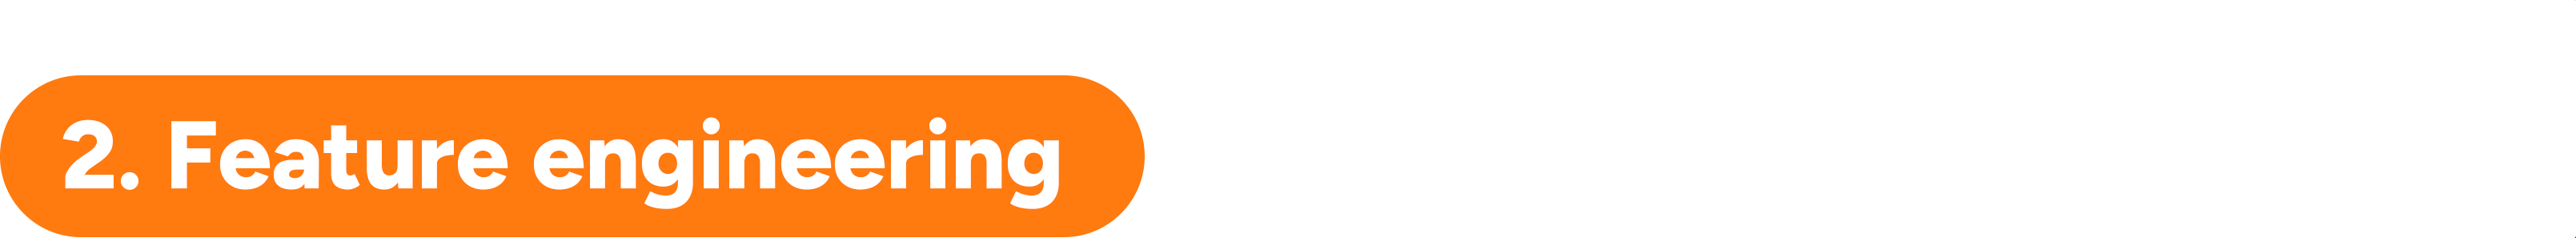

https://alphascientist.com/feature_engineering.html

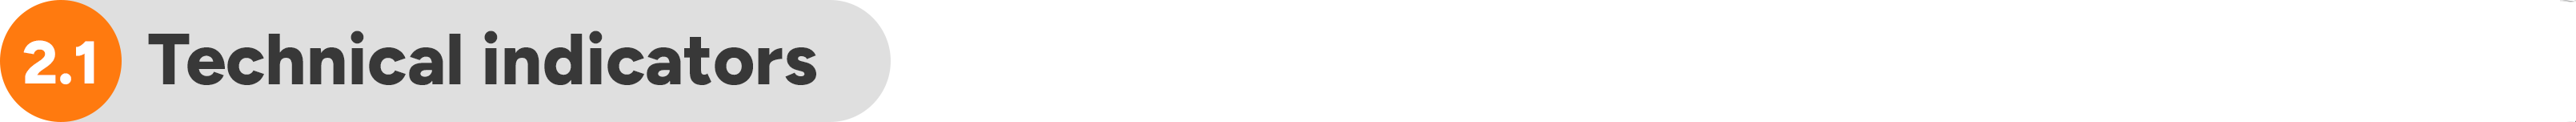

consider: spreads, changes in bid prices, changes in ask prices, differences in bid and ask volumes, volatility of bid prices, and volatility of ask prices. 

Lets just pick out AUDCHF as an example to see how the `features` df is formed for each price path.

In [31]:
# Pick out a single path to demonstrate how the features df is created
AUDCHF = forex_hourly_log_frdiff['AUDCHF']
features_AUDCHF = pd.DataFrame()

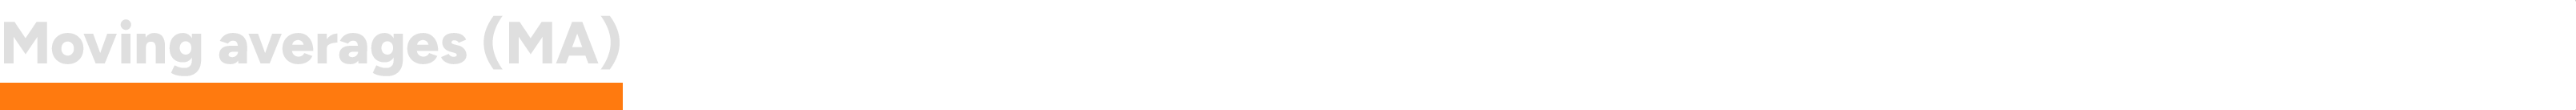

Simple moving average (sma), exponential moving average (EMA)

In [32]:
features_AUDCHF['sma_10'] = ta.trend.sma_indicator(AUDCHF, window=10)
features_AUDCHF['sma_20'] = ta.trend.sma_indicator(AUDCHF, window=20)

features_AUDCHF['ema_10'] = ta.trend.ema_indicator(AUDCHF, window=10)
features_AUDCHF['ema_20'] = ta.trend.ema_indicator(AUDCHF, window=20)

Volatility - Exponential weighted moving average (EWMA)

In [57]:
def volatility_with_log_returns(
        close: pd.Series,
        span: int = 100 # determines how much weight is assigned to the previous observations in the EWMA calculation
) -> pd.Series:
    """
    Calculate the daily volatility at intraday estimation points using Exponentially Weighted Moving Average (EWMA).

    :param close: A pandas Series of daily close prices.
    :param span: The span parameter for the Exponentially Weighted Moving Average (EWMA).
    :return: A pandas Series containing daily volatilities.

    References:
    - De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons. (Methodology: Page 44)
    """
    
    df = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    # searchsorted method returns the index of the first element in the array that is greater than the search value
        
    df = df[df > 0] # filters out the non-positive values from the df array, ensuring that only valid indices are considered
    df = pd.Series(close.index[df - 1], index=close.index[close.shape[0] - df.shape[0]:])
    returns = np.log(close.loc[df.index] / close.loc[df.values].values)
    stds = returns.ewm(span=span).std().rename("std")
    # essentially its just using an alpha param that is determined by the span, then use that as kinda like a weight
    # param for the std method nothin 2 complicated

    return stds

In [58]:
features_AUDCHF['volatility'] = volatility_with_log_returns(AUDCHF, 100)

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Consider: integrated window moving average (IWMA)

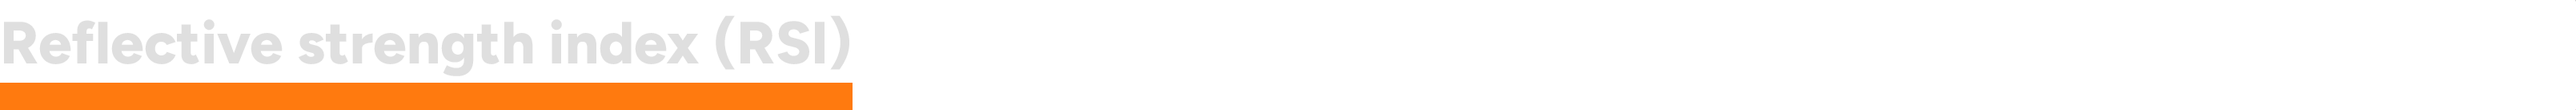

In [35]:
features_AUDCHF['rsi'] = ta.momentum.rsi(AUDCHF)
features_AUDCHF['macd'] = ta.trend.macd_diff(AUDCHF)
features_AUDCHF['bb_upper'], features_AUDCHF['bb_middle'], features_AUDCHF['bb_lower'] = \
    ta.volatility.bollinger_hband_indicator(AUDCHF), ta.volatility.bollinger_mavg(AUDCHF), \
    ta.volatility.bollinger_lband_indicator(AUDCHF)

Normalisation of features

In [37]:
features_AUDCHF.tail()

sma_10    sma_20    ema_10    ema_20  volatility  \
Date                                                                      
2024-05-07 06:00:00  0.007758  0.007890  0.007457  0.007710    0.124680   
2024-05-07 07:00:00  0.007595  0.007792  0.007243  0.007574    0.129681   
2024-05-07 08:00:00  0.007533  0.007754  0.007257  0.007550    0.129454   
2024-05-07 09:00:00  0.007465  0.007721  0.007280  0.007534    0.128565   
2024-05-07 10:00:00  0.007342  0.007707  0.007314  0.007528    0.128140   

                           rsi      macd  bb_upper  bb_middle  bb_lower  
Date                                                                     
2024-05-07 06:00:00  30.707879 -0.000230       0.0   0.007890       1.0  
2024-05-07 07:00:00  36.882664 -0.000253       0.0   0.007792       1.0  
2024-05-07 08:00:00  47.398018 -0.000187       0.0   0.007754       0.0  
2024-05-07 09:00:00  47.969636 -0.000131       0.0   0.007721       0.0  
2024-05-07 10:00:00  48.741239 -0.000083       0.0   0.007707       0.0

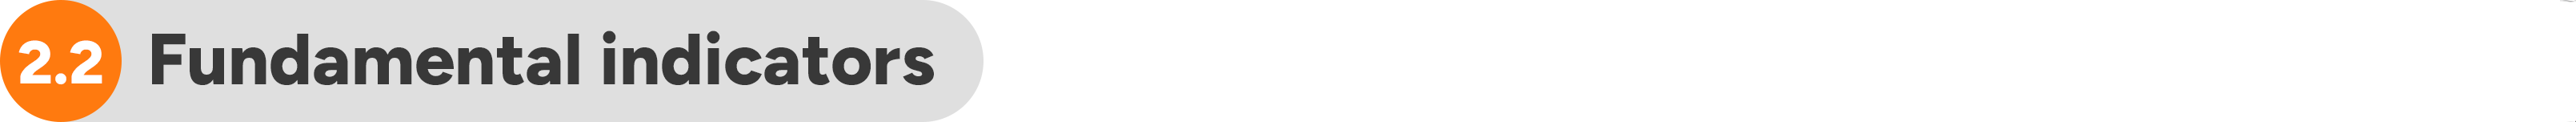

https://arxiv.org/pdf/2002.10247

Consumer Price Index (CPI) 
● Index of Industrial Production (IIP) 
● Interest Rates 
● Money Supply 
● Total Reserves 
● Stock Market Index 
● Trade (Net Exports)

news / market sentiment

https://www.epchan.com/What%20we%20learned%20from%20Kaggle%20Two-Sigma%20News%20Sentiment%20competition.pdf

Sentiment and Economic Indicators:

Interest Rates: Changes in interest rates can affect currency values.
Economic Data Releases: Reports such as GDP, employment numbers, and inflation rates can impact currency markets.
Market Sentiment Indicators: Sentiment analysis from news, social media, or trader positioning data.
Cross-Currency Relationships:

Correlations: Strength and direction of relationships between different currency pairs.
Currency Strength: Relative strength of a currency compared to others in a pair.

interest rates = fewer rows than forex price -> X work

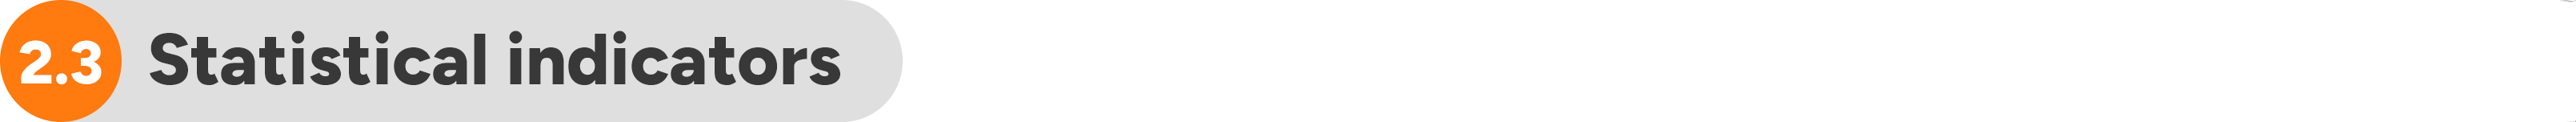

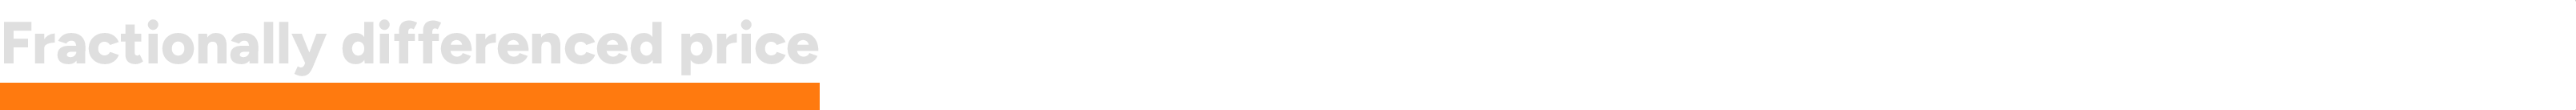

In [41]:
features_AUDCHF['frac_diff'] = forex_hourly_log_frdiff['AUDCHF']
features_AUDCHF

sma_10    sma_20    ema_10    ema_20  volatility  \
Date                                                                      
2013-03-18 22:00:00       NaN       NaN       NaN       NaN         NaN   
2013-03-18 23:00:00       NaN       NaN       NaN       NaN         NaN   
2013-03-19 00:00:00       NaN       NaN       NaN       NaN         NaN   
2013-03-19 01:00:00       NaN       NaN       NaN       NaN         NaN   
2013-03-19 02:00:00       NaN       NaN       NaN       NaN         NaN   
...                       ...       ...       ...       ...         ...   
2024-05-07 06:00:00  0.007758  0.007890  0.007457  0.007710    0.124680   
2024-05-07 07:00:00  0.007595  0.007792  0.007243  0.007574    0.129681   
2024-05-07 08:00:00  0.007533  0.007754  0.007257  0.007550    0.129454   
2024-05-07 09:00:00  0.007465  0.007721  0.007280  0.007534    0.128565   
2024-05-07 10:00:00  0.007342  0.007707  0.007314  0.007528    0.128140   

                           rsi      macd  bb_upper  bb_middle  bb_lower  \
Date                                                                      
2013-03-18 22:00:00        NaN       NaN       0.0        NaN       0.0   
2013-03-18 23:00:00        NaN       NaN       0.0        NaN       0.0   
2013-03-19 00:00:00        NaN       NaN       0.0        NaN       0.0   
2013-03-19 01:00:00        NaN       NaN       0.0        NaN       0.0   
2013-03-19 02:00:00        NaN       NaN       0.0        NaN       0.0   
...                        ...       ...       ...        ...       ...   
2024-05-07 06:00:00  30.707879 -0.000230       0.0   0.007890       1.0   
2024-05-07 07:00:00  36.882664 -0.000253       0.0   0.007792       1.0   
2024-05-07 08:00:00  47.398018 -0.000187       0.0   0.007754       0.0   
2024-05-07 09:00:00  47.969636 -0.000131       0.0   0.007721       0.0   
2024-05-07 10:00:00  48.741239 -0.000083       0.0   0.007707       0.0   

                     frac_diff  
Date                            
2013-03-18 22:00:00        NaN  
2013-03-18 23:00:00        NaN  
2013-03-19 00:00:00        NaN  
2013-03-19 01:00:00        NaN  
2013-03-19 02:00:00        NaN  
...                        ...  
2024-05-07 06:00:00   0.005783  
2024-05-07 07:00:00   0.006282  
2024-05-07 08:00:00   0.007320  
2024-05-07 09:00:00   0.007384  
2024-05-07 10:00:00   0.007466  

[65232 rows x 11 columns]

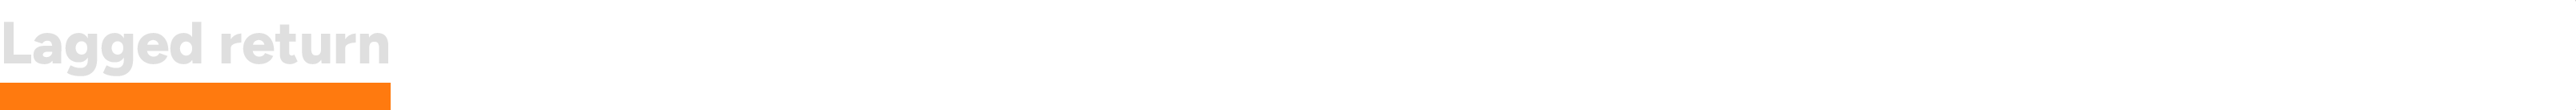

The approach of using lagged returns, and more generally past realizations of the price signal, as input for a RNN follows the recent work of Fischer and Krauss (2018), who find it to deliver highly accurate forecasts. We acknowledge that different ways to set up the forecasting tasks are possible and could consist of using technical indicators as additional signal and/or incorporating price signals from other financial instruments (e.g., other exchange rates than the one being forecast), among others

We use the time series of scaled returns as the sole feature, with the input at time t consisting of the sequence of returns of the previous trading days: https://link.springer.com/article/10.1007/s42521-020-00019-x

In [42]:
# trend from the past 1, 2, 3, 4, 5 hours
def create_lagged_features(data, pair, lag):
    df = data[[pair]].copy()
    for i in range(1, lag + 1):
        df[f'price_lag_{i}'] = df[pair].shift(i)
    return df

lagged_features = create_lagged_features(forex_hourly_log_frdiff, 'AUDCHF', lag=5) 
lagged_features

AUDCHF  price_lag_1  price_lag_2  price_lag_3  \
Date                                                                   
2013-03-18 22:00:00       NaN          NaN          NaN          NaN   
2013-03-18 23:00:00       NaN          NaN          NaN          NaN   
2013-03-19 00:00:00       NaN          NaN          NaN          NaN   
2013-03-19 01:00:00       NaN          NaN          NaN          NaN   
2013-03-19 02:00:00       NaN          NaN          NaN          NaN   
...                       ...          ...          ...          ...   
2024-05-07 06:00:00  0.005783     0.006749     0.007386     0.008368   
2024-05-07 07:00:00  0.006282     0.005783     0.006749     0.007386   
2024-05-07 08:00:00  0.007320     0.006282     0.005783     0.006749   
2024-05-07 09:00:00  0.007384     0.007320     0.006282     0.005783   
2024-05-07 10:00:00  0.007466     0.007384     0.007320     0.006282   

                     price_lag_4  price_lag_5  
Date                                           
2013-03-18 22:00:00          NaN          NaN  
2013-03-18 23:00:00          NaN          NaN  
2013-03-19 00:00:00          NaN          NaN  
2013-03-19 01:00:00          NaN          NaN  
2013-03-19 02:00:00          NaN          NaN  
...                          ...          ...  
2024-05-07 06:00:00     0.008108     0.008577  
2024-05-07 07:00:00     0.008368     0.008108  
2024-05-07 08:00:00     0.007386     0.008368  
2024-05-07 09:00:00     0.006749     0.007386  
2024-05-07 10:00:00     0.005783     0.006749  

[65232 rows x 6 columns]

In [60]:
features_AUDCHF = features_AUDCHF.merge(lagged_features.iloc[:, 1:], how = 'inner', left_index = True, right_index = True)
features_AUDCHF.tail(3)

sma_10    sma_20    ema_10    ema_20  volatility  \
Date                                                                      
2024-05-07 08:00:00  0.007533  0.007754  0.007257  0.007550    0.129454   
2024-05-07 09:00:00  0.007465  0.007721  0.007280  0.007534    0.128565   
2024-05-07 10:00:00  0.007342  0.007707  0.007314  0.007528    0.128140   

                           rsi      macd  bb_upper  bb_middle  bb_lower  ...  \
Date                                                                     ...   
2024-05-07 08:00:00  47.398018 -0.000187       0.0   0.007754       0.0  ...   
2024-05-07 09:00:00  47.969636 -0.000131       0.0   0.007721       0.0  ...   
2024-05-07 10:00:00  48.741239 -0.000083       0.0   0.007707       0.0  ...   

                     price_lag_1_x  price_lag_2_x  price_lag_3_x  \
Date                                                               
2024-05-07 08:00:00       0.006282       0.005783       0.006749   
2024-05-07 09:00:00       0.007320       0.006282       0.005783   
2024-05-07 10:00:00       0.007384       0.007320       0.006282   

                     price_lag_4_x  price_lag_5_x  price_lag_1_y  \
Date                                                               
2024-05-07 08:00:00       0.007386       0.008368       0.006282   
2024-05-07 09:00:00       0.006749       0.007386       0.007320   
2024-05-07 10:00:00       0.005783       0.006749       0.007384   

                     price_lag_2_y  price_lag_3_y  price_lag_4_y  \
Date                                                               
2024-05-07 08:00:00       0.005783       0.006749       0.007386   
2024-05-07 09:00:00       0.006282       0.005783       0.006749   
2024-05-07 10:00:00       0.007320       0.006282       0.005783   

                     price_lag_5_y  
Date                                
2024-05-07 08:00:00       0.008368  
2024-05-07 09:00:00       0.007386  
2024-05-07 10:00:00       0.006749  

[3 rows x 21 columns]

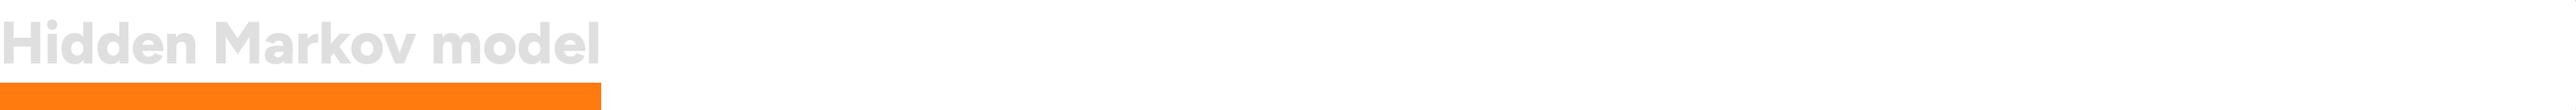

Why

When
 dealing with regime shifts, we expect Markov
 switching models to perform better than simple
 data partitions based on thresholds. For example,
 in Figure 1, if we had simply classified the observa
 tions that were in the highest quartile as being
 associated with Regime 2 (the high-mean regime),
 we would have misidentified the actual regime 40
 times out of 200 observations. In contrast, a well
 calibrated Markov-switching model would have
 misidentified the actual regime only three times.
 Arbitrary thresholds give false signals because they
 fail to capture the persistence in regimes as well as
 changing volatilities. For example, because Regime
 2 has higher volatility, a large negative value is
 most likely to come from this regime, even though
 it has a higher mean. Likewise, if the previous
 observation were volatile, the current observation
 would be more likely associated with Regime 2,
 even though a simple threshold might classify it as
 part of the quiet regime. Markov-switching models
 are designed to capture these features of the data.

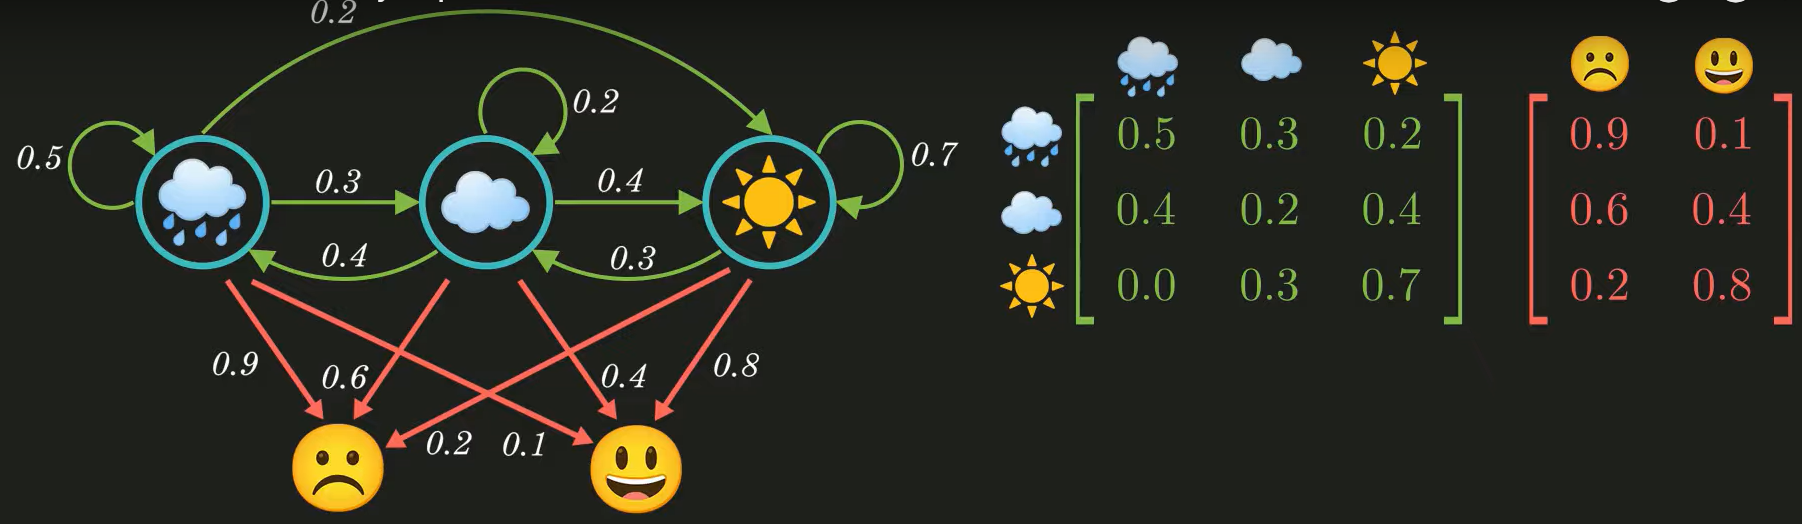

Transtition matrix = the first one - between states

Emission matrix = the second one - pr of observations being generated based on hidden states.

EACH STATE = ONLY DEPENDENT ON THE STATE THE DAY PRIOR

EACH OBSERVATIONS = ONLY DEPENDENT ON TODAY'S STATE

**HMM Tasks**
* Evaluation: Given a model and a sequence of observations, compute the probability of the observations.
* Decoding: Given a model and a sequence of observations, find the most likely sequence of hidden states.
* Learning: Given a sequence of observations, adjust the model parameters to best fit the data.

Since we dont have the model -> we wanna learn from the data -> EM algorithm / Baum-Welch

**Steps to Train an HMM**
* Initialisation: Start with random guesses for the model parameters (transition and emission probabilities).
* Expectation Step: Compute the expected values of the hidden states using the current parameters (Forward-Backward algorithm).
* Maximisation Step: Re-estimate the model parameters to maximise the likelihood of the observed data.
* Iteration: Repeat the Expectation and Maximisation steps until convergence.

To do
1. Define regimes
2. Create transitn matrix and calibrate initial and trans probability
3. Simulate

2 state assumption

we assumed that observations from Regime 1 were normally distributed with a given mean and stan dard deviation and that observations from Regime 2 were normally distributed with a different mean and standard deviation. Sev

**Types of Regime Switching Models**
1. Markov Switching Autoregressive Model (MS-AR)

2. Markov Switching Vector Autoregressive Model (MS-VAR)

3. Markov Switching GARCH Model (MS-GARCH)

**Estimation**
1. Maximum Likelihood Estimation (MLE)

* most common
2. Expectation-Maximisation (EM)
* E: algorithm calculates the expected value of the complete data log-likelihood, given the observed data and current parameter estimates (State Probabilities & Expected Log-Likelihood)
* M: maximises the expected log-likelihood obtained from the E-step; Update / re-estimate the parameters (e.g., transition probabilities, state-specific means, and variances) to maximise the expected log-likelihood. Iterate until the changes in parameter estimates are sufficiently small, indicating convergence.

3. Baum-Welch algorithm
* specific instance of the EM algorithm (#2) used for Hidden Markov Models (HMMs)

**THIS ONE = BAUM WELCH; two state model governed by simple discrete distribution**


https://github.com/tianyu-z/Kritzman-Regime-Detection/tree/master

https://scikit-learn.sourceforge.net/stable/modules/hmm.html

https://medium.com/analytics-vidhya/baum-welch-algorithm-for-training-a-hidden-markov-model-part-2-of-the-hmm-series-d0e393b4fb86`

https://github.com/lopatovsky/HMMs/blob/master/hmms.ipynb

https://github.com/hmmlearn/hmmlearn/blob/main/examples/plot_gaussian_model_selection.py

In [96]:
def hmm_model(data, num_states = 2, n_iter = 100):

    model = hmm.GaussianHMM(n_components=num_states, n_iter=100)
    data = data.to_frame()
    model.fit(data)

    state_probabilities = model.predict_proba(data.values.reshape(-1, 1))

    hidden_states = model.predict(data.values.reshape(-1, 1))

    df = pd.DataFrame({
        'date': data.index,              
        'close': data.values.flatten(),  
        'hidden_state': hidden_states,
        'prob_state_0': state_probabilities[:, 0],
        'prob_state_1': state_probabilities[:, 1],
    })

    return df

def hmm_model_train_test(train_data, test_data, num_states=2, n_iter=100):
    """
    Fit HMM on training data and predict probabilities for test data.
    """
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    
    model = hmm.GaussianHMM(n_components=num_states, n_iter=n_iter)
    model.fit(train_data)
        
    test_state_probabilities = model.predict_proba(test_data)
    hidden_states = model.predict(test_data)

    df = pd.DataFrame({
        'date': test_data.index,              
        'close': test_data.values.flatten(),  
        'hidden_state': hidden_states,
        'prob_state_0': test_state_probabilities[:, 0],
        'prob_state_1': test_state_probabilities[:, 1],
    }).set_index('date').sort_index()

    return df

In [80]:
forex_hourly_log_frdiff.dropna(inplace = True)
test_no_split = hmm_model(forex_hourly_log_frdiff['AUDCHF'], num_states = 2, n_iter = 100)
display(test_no_split)
test_no_split['hidden_state'].value_counts()

date     close  hidden_state   prob_state_0  prob_state_1
0     2013-04-11 05:00:00  0.043342             1  1.153323e-148  1.000000e+00
1     2013-04-11 06:00:00  0.044520             1   9.444672e-13  1.000000e+00
2     2013-04-11 07:00:00  0.045911             1   3.634202e-13  1.000000e+00
3     2013-04-11 08:00:00  0.045048             1   6.582768e-13  1.000000e+00
4     2013-04-11 09:00:00  0.043236             1   2.250275e-12  1.000000e+00
...                   ...       ...           ...            ...           ...
64855 2024-05-07 06:00:00  0.005783             0   1.000000e+00  1.007974e-08
64856 2024-05-07 07:00:00  0.006282             0   1.000000e+00  1.225372e-08
64857 2024-05-07 08:00:00  0.007320             0   1.000000e+00  1.889004e-08
64858 2024-05-07 09:00:00  0.007384             0   9.999999e-01  8.355375e-08
64859 2024-05-07 10:00:00  0.007466             0   9.999894e-01  1.056579e-05

[64860 rows x 5 columns]

hidden_state
0    33836
1    31024
Name: count, dtype: int64

<Axes: >

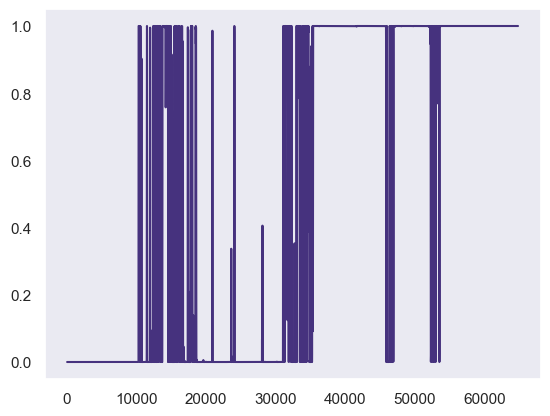

In [81]:
test_no_split['prob_state_0'].plot()

date     close  hidden_state   prob_state_0  prob_state_1
0     2013-03-18 22:00:00  0.368536             1  5.352637e-123  1.000000e+00
1     2013-03-18 23:00:00  0.368176             1   3.259219e-16  1.000000e+00
2     2013-03-19 00:00:00  0.367542             1   3.518561e-16  1.000000e+00
3     2013-03-19 01:00:00  0.367530             1   3.523956e-16  1.000000e+00
4     2013-03-19 02:00:00  0.367639             1   3.477876e-16  1.000000e+00
...                   ...       ...           ...            ...           ...
65227 2024-05-07 06:00:00  0.057483             0   1.000000e+00  1.101028e-09
65228 2024-05-07 07:00:00  0.057459             0   1.000000e+00  1.108769e-09
65229 2024-05-07 08:00:00  0.058287             0   1.000000e+00  1.823155e-09
65230 2024-05-07 09:00:00  0.058489             0   9.999999e-01  5.363812e-08
65231 2024-05-07 10:00:00  0.058643             0   9.999961e-01  3.947221e-06

[65232 rows x 5 columns]

hidden_state
1    34646
0    30586
Name: count, dtype: int64


<Axes: >

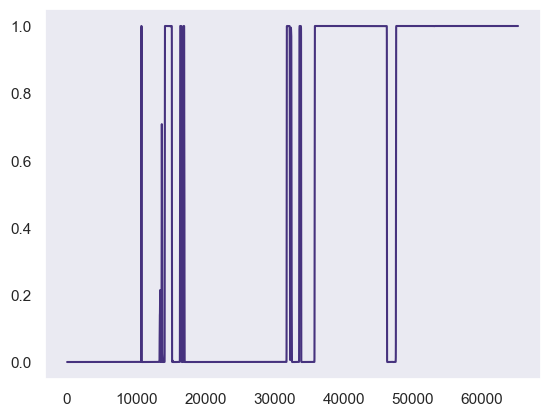

In [89]:
forex_hourly_log.dropna(inplace = True)
test_no_split_nofrdiff = hmm_model(forex_hourly_log['AUDCHF'], num_states = 2, n_iter = 100)
display(test_no_split_nofrdiff)
print(test_no_split_nofrdiff['hidden_state'].value_counts())
test_no_split_nofrdiff['prob_state_0'].plot()

train test set split

Length of train set: 32616
Length of test set: 32616


close  hidden_state  prob_state_0  prob_state_1
date                                                                   
2013-03-18 23:00:00  0.368176             1      0.003032      0.996968
2013-03-19 00:00:00  0.367542             1      0.005552      0.994448
2013-03-19 01:00:00  0.367530             1      0.005164      0.994836
2013-03-19 03:00:00  0.367684             1      0.003880      0.996120
2013-03-19 06:00:00  0.367147             1      0.006096      0.993904
...                       ...           ...           ...           ...
2024-05-07 03:00:00  0.060539             0      0.757175      0.242825
2024-05-07 04:00:00  0.059648             0      0.648736      0.351264
2024-05-07 06:00:00  0.057483             0      0.766382      0.233618
2024-05-07 07:00:00  0.057459             0      0.646244      0.353756
2024-05-07 10:00:00  0.058643             0      0.629810      0.370190

[32616 rows x 4 columns]

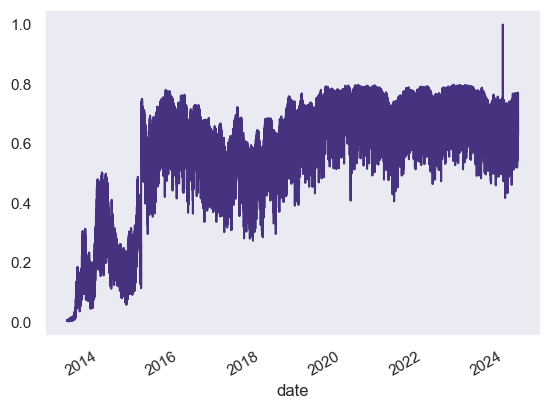

In [93]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(forex_hourly_log['AUDCHF'], test_size = 0.5, random_state = 404)
print(f'Length of train set: {len(train_set)}')
print(f'Length of test set: {len(test_set)}')
train_set[:10]


split = hmm_model_train_test(train_set, test_set, num_states=2, n_iter=100)
split['prob_state_0'].plot()
split

Model is not converging.  Current: 110485.11605399869 is not greater than 110485.13166828592. Delta is -0.015614287229254842


Length of train set2: 32430
Length of test set2: 32430


close  hidden_state  prob_state_0  prob_state_1
date                                                                   
2013-04-11 06:00:00  0.044520             1      0.148709      0.851291
2013-04-11 07:00:00  0.045911             1      0.185322      0.814678
2013-04-11 08:00:00  0.045048             1      0.146216      0.853784
2013-04-11 10:00:00  0.043401             1      0.102056      0.897944
2013-04-11 13:00:00  0.043965             1      0.135460      0.864540
...                       ...           ...           ...           ...
2024-05-07 03:00:00  0.008368             1      0.004108      0.995892
2024-05-07 04:00:00  0.007386             1      0.006128      0.993872
2024-05-07 06:00:00  0.005783             1      0.005769      0.994231
2024-05-07 07:00:00  0.006282             1      0.005170      0.994830
2024-05-07 10:00:00  0.007466             1      0.007853      0.992147

[32430 rows x 4 columns]

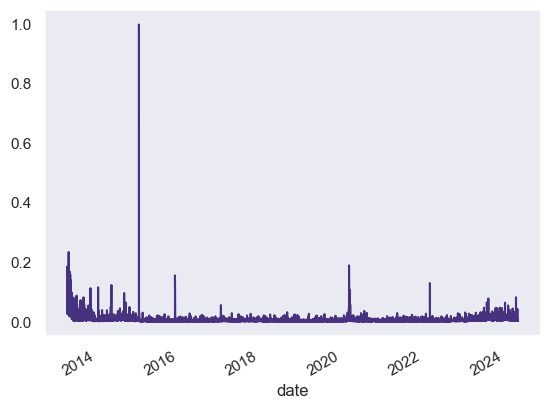

In [94]:
train_set2, test_set2 = train_test_split(forex_hourly_log_frdiff['AUDCHF'], test_size = 0.5, random_state = 404)
print(f'Length of train set2: {len(train_set2)}')
print(f'Length of test set2: {len(test_set2)}')
train_set2[:10]


split = hmm_model_train_test(train_set2, test_set2, num_states=2, n_iter=100)
split['prob_state_0'].plot()
split

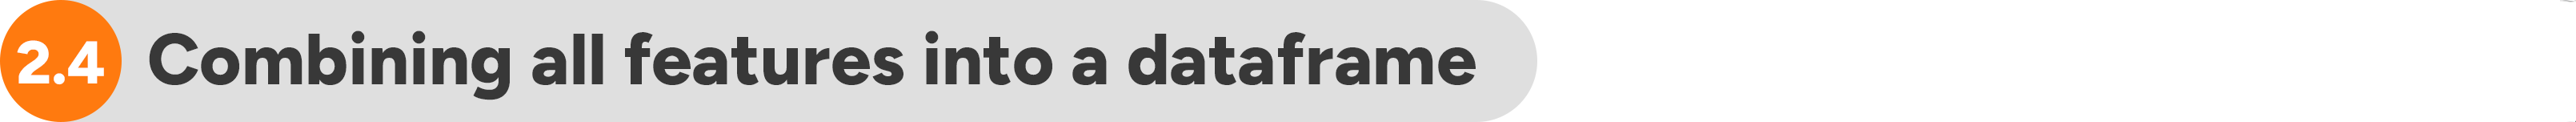

<div class="alert alert-success">
<b>KEY DATAFRAME: forex_daily_log_frdiff</b>
</div>

In [59]:
for pair in forex_hourly_log_frdiff.columns:
    features = pd.DataFrame()
    price = forex_hourly_log[pair]

    # technical indicators
    features['sma_10'] = ta.trend.sma_indicator(price, window=10)
    features['sma_20'] = ta.trend.sma_indicator(price, window=20)
    features['ema_10'] = ta.trend.ema_indicator(price, window=10)
    features['ema_20'] = ta.trend.ema_indicator(price, window=20)
    features['volatility'] = volatility_with_log_returns(price, 100)

    # statistical indicators
    features['frac_diff'] = forex_hourly_log_frdiff[pair]
    hmm_result_df = hmm_model(forex_hourly_log, pair, num_states = 2, n_iter = 100)
    features['prob_state_0'] = hmm_result_df.loc[:, 'prob_state_0'].values
    features['prob_state_1'] = hmm_result_df.loc[:, 'prob_state_1'].values

    features['rsi'] = ta.momentum.rsi(price)
    features['macd'] = ta.trend.macd_diff(price)
    features['bb_upper'] = ta.volatility.bollinger_hband(price)
    features['bb_middle'] = ta.volatility.bollinger_mavg(price)
    features['bb_lower'] = ta.volatility.bollinger_lband(price)

    # fundamental indicators

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: DataFrame constructor not properly called!

In [ ]:
features

sma_10    sma_20    ema_10    ema_20  volatility  frac_diff  \
Date                                                                        
2013-03-18       NaN       NaN       NaN       NaN         NaN        NaN   
2013-03-19       NaN       NaN       NaN       NaN         NaN        NaN   
2013-03-20       NaN       NaN       NaN       NaN         NaN        NaN   
2013-03-21       NaN       NaN       NaN       NaN    0.001484        NaN   
2013-03-22       NaN       NaN       NaN       NaN    0.001088        NaN   
...              ...       ...       ...       ...         ...        ...   
2024-05-02  3.314640  3.337436  3.314119  3.317087    0.005756   0.753114   
2024-05-03  3.310602  3.334702  3.310546  3.314932    0.005699   0.772505   
2024-05-05  3.308678  3.332006  3.307869  3.313113    0.005642   0.839130   
2024-05-06  3.308356  3.329108  3.309601  3.313520    0.005659   1.426527   
2024-05-07  3.308342  3.327732  3.312019  3.314413    0.005703   1.265607   

            prob_state_0  prob_state_1        rsi      macd  bb_upper  \
Date                                                                    
2013-03-18      0.000149      0.999851        NaN       NaN       NaN   
2013-03-19      0.983893      0.016107        NaN       NaN       NaN   
2013-03-20      0.072094      0.927906        NaN       NaN       NaN   
2013-03-21      0.917210      0.082790        NaN       NaN       NaN   
2013-03-22      0.133895      0.866105        NaN       NaN       NaN   
...                  ...           ...        ...       ...       ...   
2024-05-02      0.510565      0.489435  43.239625 -0.010781  3.388318   
2024-05-03      0.510861      0.489139  43.127432 -0.010288  3.388562   
2024-05-05      0.510521      0.489479  43.806410 -0.009468  3.387943   
2024-05-06      0.510906      0.489094  53.345074 -0.007174  3.381667   
2024-05-07      0.510462      0.489538  55.425297 -0.005085  3.379419   

            bb_middle  bb_lower  
Date                             
2013-03-18        NaN       NaN  
2013-03-19        NaN       NaN  
2013-03-20        NaN       NaN  
2013-03-21        NaN       NaN  
2013-03-22        NaN       NaN  
...               ...       ...  
2024-05-02   3.337436  3.286554  
2024-05-03   3.334702  3.280842  
2024-05-05   3.332006  3.276069  
2024-05-06   3.329108  3.276550  
2024-05-07   3.327732  3.276044  

[3445 rows x 13 columns]

<Axes: xlabel='Date'>

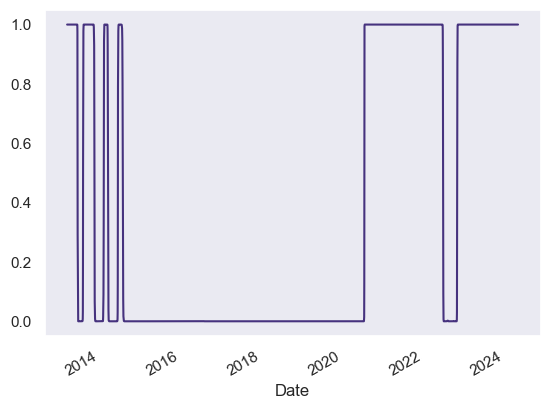

In [ ]:
features['prob_state_0'].plot()

drop na

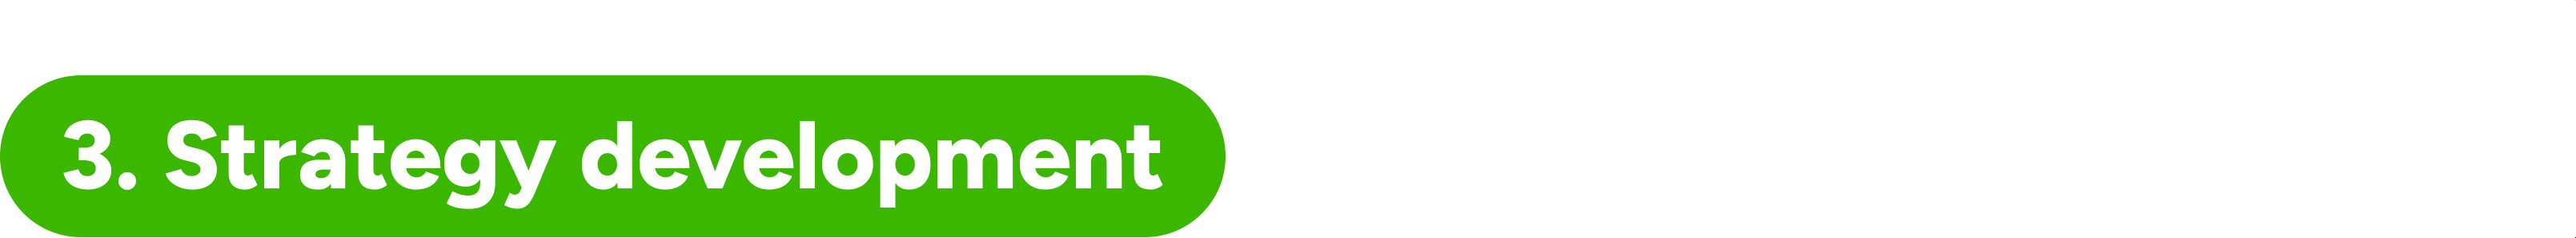

Simplest strat: classic moving average crossover type.

At every bar calculate the 10-day and 30-day simple moving averages (SMA)

If the 10-day SMA exceeds the 30-day SMA and the strategy is not invested, then go long

If the 30-day SMA exceeds the 10-day SMA and the strategy is invested, then close the position

https://arxiv.org/pdf/2009.10065

file:///C:/Users/kalul/Downloads/Dataselectionpairsavoidoverfitting.pdf


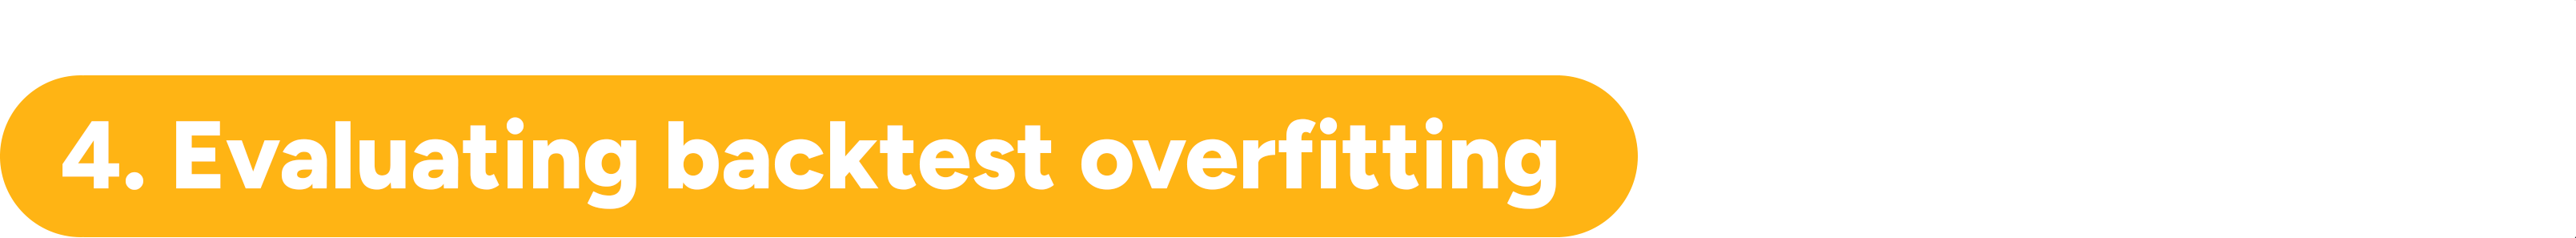